In [1]:
from crim_intervals import *
import pandas as pd
import ast
import matplotlib
from itertools import tee, combinations
import numpy as np

In [2]:
# THIS IS DEV COPY for use with CLOSE/EXACT Matches

import numpy as np

# Converts lists to tuples

def lists_to_tuples_a(el):
    if isinstance(el, list):
        return tuple(el)
    else:
        return el

# Filters for the length of the Presentation Type in the Classifier

def limit_offset_size(array, limit):
    under_limit = np.cumsum(array) <= limit
    return array[: sum(under_limit)]

# Gets the the list of offset differences for each group 

def get_offset_difference_list_a(group):
    # if we do sort values as part of the func call, then we don't need this first line
    group = group.sort_values("start_offset")
    group["next_offset"] = group.start_offset.shift(-1)
    offset_difference_list = (group.next_offset - group.start_offset).dropna().tolist()
    return offset_difference_list

# The classifications are done here
# be sure to have the offset difference limit set here and matched in gap check below  80 = ten bars

def classify_offsets_a(offset_difference_list):
    """
    Put logic for classifying an offset list here
    """
    # 
    offset_difference_list = limit_offset_size(offset_difference_list, 500)
    
    alt_list = offset_difference_list[::2]
    
    if len(set(offset_difference_list)) == 1 and len(offset_difference_list) > 1:
        return ("PEN", offset_difference_list)
    # elif (len(offset_difference_list) %2 != 0) and (len(set(alt_list)) == 1):
    elif (len(offset_difference_list) %2 != 0) and (len(set(alt_list)) == 1) and (len(offset_difference_list) >= 3):
        return ("ID", offset_difference_list)
    elif len(offset_difference_list) >= 1:
        return ("Fuga", offset_difference_list)
    else: 
        return ("Singleton", offset_difference_list)
    
# adds predicted type, offsets and entry numbers to the results

def predict_type_a(group):
    offset_differences = get_offset_difference_list_a(group)
    predicted_type, offsets = classify_offsets_a(offset_differences)

    group["predicted_type"] = [predicted_type for i in range(len(group))]
    group["offset_diffs"] = [offsets for i in range(len(group))]
    group["entry_number"] = [i + 1 for i in range(len(group))]

    return group

In [91]:
# read CSV output of CRIM Intervals Search.

df = pd.read_csv(('A_Test_Files/ave_test_set.csv'), index_col=0)
df = df.drop(columns=["ema", "ema_url", "end_measure", "end_beat"])
df.head()


,pattern_generating_match,pattern_matched,piece_title,part,start_measure,start_beat,start_offset,end_offset,note_durations,sum_durs
0,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,[Superius],1,1.0,0.0,24.0,"[4.0, 8.0, 4.0, 4.0, 4.0, 8.0]",32.0
1,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,[Superius],105,3.0,884.0,910.0,"[4.0, 8.0, 4.0, 4.0, 6.0, 2.0]",28.0
2,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Altus,3,1.0,16.0,40.0,"[4.0, 8.0, 4.0, 4.0, 4.0, 8.0]",32.0
3,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Tenor,5,1.0,32.0,56.0,"[4.0, 8.0, 4.0, 4.0, 4.0, 8.0]",32.0
4,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Bassus,7,1.0,48.0,72.0,"[4.0, 8.0, 4.0, 4.0, 4.0, 8.0]",32.0


In [92]:
# lists for views.  These are used when calling the df below

simple_view = ["piece_title", "part", "pattern_generating_match", "pattern_matched", "start_offset"]

offset_details = ["start_measure", "start_beat", "end_offset", "note_durations", "prev_entry_off", "next_entry_off"]

drop_cols = ["pattern_matched", "part", "pattern_generating_match", "piece_title", "start_measure", "start_beat", "end_offset", "note_durations", "prev_entry_off", "next_entry_off"]

ready_classify = ["pattern_generating_match", "pattern_matched", "piece_title", "part", "start_measure", "start_beat", "start_offset", "sub_group_id", "is_first"]

In [93]:
df['note_durations'] = df.note_durations.apply(ast.literal_eval)
df["sum_durs"] = df.note_durations.apply(sum)

In [94]:
# now process the original match data df by:
# sorting by start offset, then group by pattern generating match and applying the function above for prev entry
# also give each group a number
# sort by group number and start offset
# so that we can find PARALLEL (=0) Forward Gaps (the distance to NEXT entry), and Backward Gaps (distance to PREVIOUS Entry)
# All Proximate Matches are part of same sub Group (and go to classifier)
# Parallels are part of Sub Group but NOT part of Classified.  We will filter them OUT before classification
# Forward ONLY means the NEXT entry is a GAP.  No problem for Forward ONLY, since these are part of the previous set.
# Backward ONLY means the LAST entry was a GAP.  So these are NEW subgroups, since a new Presentation Type begins
# Forward AND Backward Gaps are SINGLETONS:  We will filter then OUT before Classification
# If an entry is the LAST in a Group and also has a BACKWARD gap it is also a SINGLETON

df2 = df
# df2 = df.sort_values("start_offset")

# Make Groups, Sort By Group and Offset, then and Add Previous/Next
df2["group_number"] = df2.groupby('pattern_generating_match').ngroup()
df2 = df2.sort_values(['group_number', 'start_offset'])
df2["prev_entry_off"] = df2["start_offset"].shift(1)
df2["next_entry_off"] = df2["start_offset"].shift(-1)


first_of_group = df2.drop_duplicates(subset=["pattern_generating_match"], keep='first').index
df2["is_first"] = df2.index.isin(first_of_group)
last_of_group = df2.drop_duplicates(subset=["pattern_generating_match"], keep='last').index
df2["is_last"] = df2.index.isin(last_of_group)

# Check Differences between Next and Last Offset

df2["last_off_diff"] = df2["start_offset"] - df2["prev_entry_off"]
df2["next_off_diff"] = df2["next_entry_off"] - df2["start_offset"]

# Find Parallel Entries 
df2["parallel"] = df2["last_off_diff"] == 0

# Set Gap Limits and Check Gaps Forward and Back
df2["forward_gapped"] = df2["next_off_diff"] >= 50
df2["back_gapped"] = df2["last_off_diff"] >= 50

# Find Singletons and Split Groups with Gaps
df2["singleton"] = ((df2['forward_gapped'] == True) & (df2['back_gapped'] == True) | (df2['back_gapped'] == True) & (df2["is_last"]))
df2["split_group"] = (df2['forward_gapped'] == False) & (df2['back_gapped'] == True)

#Mask Out Parallels and Singletons
df2 = df2[df2["parallel"] != True]
df2 = df2[df2["singleton"] != True]
df2["next_off_diff"] = df2["next_off_diff"].abs()
df2["last_off_diff"] = df2["last_off_diff"].abs()

# Find Final Groups
df2["combined_group"] = (df2.split_group | df2.is_first)
df2.loc[(df2["combined_group"]), "sub_group_id"] = range(df2.combined_group.sum())
df2["sub_group_id"] = df2["sub_group_id"].ffill()


df2.head()


,pattern_generating_match,pattern_matched,piece_title,part,start_measure,start_beat,start_offset,end_offset,note_durations,sum_durs,...,is_last,last_off_diff,next_off_diff,parallel,forward_gapped,back_gapped,singleton,split_group,combined_group,sub_group_id
18,"(-2, -2, -2, -2, -2)","[-2, -2, -2, -2, -2]",Ave Maria,[Superius],19,1.0,144.0,156.0,"[3.0, 1.0, 2.0, 2.0, 4.0, 2.0]",14.0,...,False,NaN,14.0,False,False,False,False,False,True,0.0
19,"(-2, -2, -2, -2, -2)","[-2, -2, -2, -2, -2]",Ave Maria,[Superius],20,4.0,158.0,172.0,"[3.0, 1.0, 4.0, 2.0, 4.0, 4.0]",18.0,...,False,14.0,58.0,False,True,False,False,False,False,0.0
71,"(-2, -2, -2, -2, -3)","[-2, -2, -2, -2, -3]",Ave Maria,[Superius],42,1.0,328.0,348.0,"[6.0, 2.0, 4.0, 4.0, 4.0, 4.0]",24.0,...,False,344.0,0.0,False,False,False,False,False,True,1.0
177,"(-2, -2, -2, -2, 1)","[-2, -2, -2, -2, 1]",Ave Maria,Altus,95,1.0,756.0,776.0,"[6.0, 2.0, 2.0, 2.0, 8.0, 4.0]",24.0,...,False,132.0,48.0,False,False,False,False,False,True,2.0
178,"(-2, -2, -2, -2, 1)","[-2, -2, -2, -2, 1]",Ave Maria,Altus,99,1.0,804.0,824.0,"[6.0, 2.0, 2.0, 2.0, 8.0, 4.0]",24.0,...,False,48.0,60.0,False,True,False,False,False,False,2.0


In [95]:
# mask out short soggetti

# df2 = df2[df2["sum_durs"] >= 5]

df2.head()

,pattern_generating_match,pattern_matched,piece_title,part,start_measure,start_beat,start_offset,end_offset,note_durations,sum_durs,...,is_last,last_off_diff,next_off_diff,parallel,forward_gapped,back_gapped,singleton,split_group,combined_group,sub_group_id
18,"(-2, -2, -2, -2, -2)","[-2, -2, -2, -2, -2]",Ave Maria,[Superius],19,1.0,144.0,156.0,"[3.0, 1.0, 2.0, 2.0, 4.0, 2.0]",14.0,...,False,NaN,14.0,False,False,False,False,False,True,0.0
19,"(-2, -2, -2, -2, -2)","[-2, -2, -2, -2, -2]",Ave Maria,[Superius],20,4.0,158.0,172.0,"[3.0, 1.0, 4.0, 2.0, 4.0, 4.0]",18.0,...,False,14.0,58.0,False,True,False,False,False,False,0.0
71,"(-2, -2, -2, -2, -3)","[-2, -2, -2, -2, -3]",Ave Maria,[Superius],42,1.0,328.0,348.0,"[6.0, 2.0, 4.0, 4.0, 4.0, 4.0]",24.0,...,False,344.0,0.0,False,False,False,False,False,True,1.0
177,"(-2, -2, -2, -2, 1)","[-2, -2, -2, -2, 1]",Ave Maria,Altus,95,1.0,756.0,776.0,"[6.0, 2.0, 2.0, 2.0, 8.0, 4.0]",24.0,...,False,132.0,48.0,False,False,False,False,False,True,2.0
178,"(-2, -2, -2, -2, 1)","[-2, -2, -2, -2, 1]",Ave Maria,Altus,99,1.0,804.0,824.0,"[6.0, 2.0, 2.0, 2.0, 8.0, 4.0]",24.0,...,False,48.0,60.0,False,True,False,False,False,False,2.0


<AxesSubplot:>

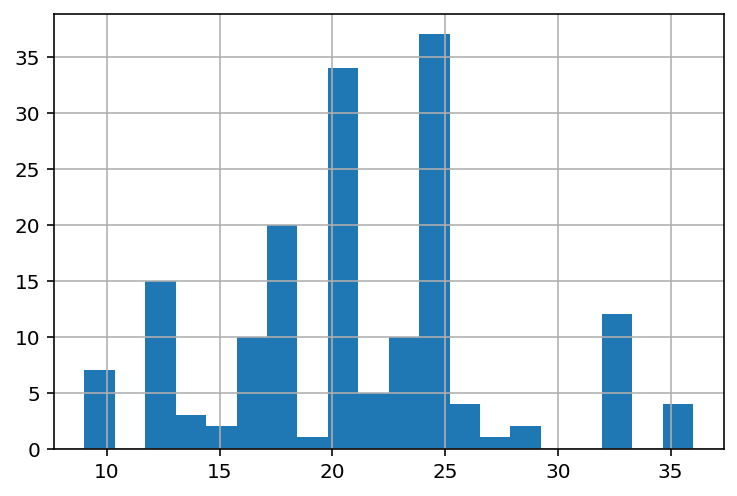

In [96]:
df2.sum_durs.hist(bins = 20)

In [97]:
# compact view for inspection of relevant columns


df3 = df2[ready_classify]
df3.shape

(167, 9)

In [103]:
# run the classifier on the newly curated list of groups

classified2 = df3.applymap(lists_to_tuples_a).groupby("sub_group_id").apply(predict_type_a)

# drop the new singletons

# classified2.drop(classified2[classified2['predicted_type'] == "Singleton"].index, inplace = True)


# # classified2 = classified2[classified2["predicted_type"] == "ID"]


classified2["start"] = classified2["start_measure"].astype(str) +"/"+ classified2["start_beat"].astype(str) 
c3 = classified2.drop(columns=['start_measure', 'start_beat','offset_diffs'])
c3.head()



,pattern_generating_match,pattern_matched,piece_title,part,start_offset,sub_group_id,is_first,predicted_type,entry_number,start
18,"(-2, -2, -2, -2, -2)","[-2, -2, -2, -2, -2]",Ave Maria,[Superius],144.0,0.0,True,Fuga,1,19/1.0
19,"(-2, -2, -2, -2, -2)","[-2, -2, -2, -2, -2]",Ave Maria,[Superius],158.0,0.0,False,Fuga,2,20/4.0
71,"(-2, -2, -2, -2, -3)","[-2, -2, -2, -2, -3]",Ave Maria,[Superius],328.0,1.0,True,Singleton,1,42/1.0
177,"(-2, -2, -2, -2, 1)","[-2, -2, -2, -2, 1]",Ave Maria,Altus,756.0,2.0,True,Fuga,1,95/1.0
178,"(-2, -2, -2, -2, 1)","[-2, -2, -2, -2, 1]",Ave Maria,Altus,804.0,2.0,False,Fuga,2,99/1.0


In [104]:
# put things back in order by offset and group them again

c4 = c3.sort_values(by = ["start_offset"])
c5 = c4.groupby(by = ["sub_group_id"])
c6 = c5.head(50)
c7 = c6.groupby(by = ["sub_group_id"])
c8 = c7.head(50)
c8.head()
# c6.to_csv("new-test-1.csv")


,pattern_generating_match,pattern_matched,piece_title,part,start_offset,sub_group_id,is_first,predicted_type,entry_number,start
0,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,[Superius],0.0,55.0,True,PEN,1,1/1.0
2,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Altus,16.0,55.0,False,PEN,2,3/1.0
3,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Tenor,32.0,55.0,False,PEN,3,5/1.0
4,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Bassus,48.0,55.0,False,PEN,4,7/1.0
5,"(-2, -2, -2, 2, -2)","[-2, -2, -2, 2, -2]",Ave Maria,[Superius],56.0,7.0,True,PEN,1,8/1.0


In [105]:

c9 = c8.sort_values(by = ["sub_group_id", "entry_number"])
c9.tail()

,pattern_generating_match,pattern_matched,piece_title,part,start_offset,sub_group_id,is_first,predicted_type,entry_number,start
128,"(4, -2, 2, 2, -3)","[4, -2, 2, 2, -3]",Ave Maria,Bassus,472.0,54.0,False,ID,4,60/1.0
0,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,[Superius],0.0,55.0,True,PEN,1,1/1.0
2,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Altus,16.0,55.0,False,PEN,2,3/1.0
3,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Tenor,32.0,55.0,False,PEN,3,5/1.0
4,"(4, 1, 2, 2, -3)","[4, 1, 2, 2, -3]",Ave Maria,Bassus,48.0,55.0,False,PEN,4,7/1.0


In [106]:
#df["pattern"] = df["pattern"].apply(tuple)
wide_df = c9.pivot_table(index=["predicted_type", "pattern_generating_match", "pattern_matched"],
            columns="entry_number",
            values=["part", "start_offset", "start"],
            aggfunc=lambda x: x)
sorted_wide = wide_df.sort_values(by = [("start_offset", 1)])

sorted_wide.head()

part  \
entry_number                                                          1   
predicted_type pattern_generating_match pattern_matched                   
PEN            (4, 1, 2, 2, -3)         [4, 1, 2, 2, -3]     [Superius]   
               (-2, -2, -2, 2, -2)      [-2, -2, -2, 2, -2]  [Superius]   
Singleton      (-2, -2, -2, 2, 2)       [-2, -2, -2, 2, 2]       Bassus   
PEN            (1, 1, 2, 2, -3)         [1, 1, 2, 2, -3]     [Superius]   
Singleton      (2, 2, -3, -2, -2)       [2, 2, -3, -2, -2]   [Superius]   

                                                                           \
entry_number                                                     2      3   
predicted_type pattern_generating_match pattern_matched                     
PEN            (4, 1, 2, 2, -3)         [4, 1, 2, 2, -3]     Altus  Tenor   
               (-2, -2, -2, 2, -2)      [-2, -2, -2, 2, -2]  Altus  Tenor   
Singleton      (-2, -2, -2, 2, 2)       [-2, -2, -2, 2, 2]     NaN    NaN   
PEN            (1, 1, 2, 2, -3)         [1, 1, 2, 2, -3]     Altus  Tenor   
Singleton      (2, 2, -3, -2, -2)       [2, 2, -3, -2, -2]     NaN    NaN   

                                                                               \
entry_number                                                      4    5    6   
predicted_type pattern_generating_match pattern_matched                         
PEN            (4, 1, 2, 2, -3)         [4, 1, 2, 2, -3]     Bassus  NaN  NaN   
               (-2, -2, -2, 2, -2)      [-2, -2, -2, 2, -2]     NaN  NaN  NaN   
Singleton      (-2, -2, -2, 2, 2)       [-2, -2, -2, 2, 2]      NaN  NaN  NaN   
PEN            (1, 1, 2, 2, -3)         [1, 1, 2, 2, -3]     Bassus  NaN  NaN   
Singleton      (2, 2, -3, -2, -2)       [2, 2, -3, -2, -2]      NaN  NaN  NaN   

                                                                   start  \
entry_number                                                   7       1   
predicted_type pattern_generating_match pattern_matched                    
PEN            (4, 1, 2, 2, -3)         [4, 1, 2, 2, -3]     NaN   1/1.0   
               (-2, -2, -2, 2, -2)      [-2, -2, -2, 2, -2]  NaN   8/1.0   
Singleton      (-2, -2, -2, 2, 2)       [-2, -2, -2, 2, 2]   NaN  14/1.0   
PEN            (1, 1, 2, 2, -3)         [1, 1, 2, 2, -3]     NaN  16/3.0   
Singleton      (2, 2, -3, -2, -2)       [2, 2, -3, -2, -2]   NaN  17/3.0   

                                                                             \
entry_number                                                      2       3   
predicted_type pattern_generating_match pattern_matched                       
PEN            (4, 1, 2, 2, -3)         [4, 1, 2, 2, -3]      3/1.0   5/1.0   
               (-2, -2, -2, 2, -2)      [-2, -2, -2, 2, -2]  10/1.0  12/1.0   
Singleton      (-2, -2, -2, 2, 2)       [-2, -2, -2, 2, 2]      NaN     NaN   
PEN            (1, 1, 2, 2, -3)         [1, 1, 2, 2, -3]     18/3.0  20/3.0   
Singleton      (2, 2, -3, -2, -2)       [2, 2, -3, -2, -2]      NaN     NaN   

                                                             ...            \
entry_number                                                 ...    5    6   
predicted_type pattern_generating_match pattern_matched      ...             
PEN            (4, 1, 2, 2, -3)         [4, 1, 2, 2, -3]     ...  NaN  NaN   
               (-2, -2, -2, 2, -2)      [-2, -2, -2, 2, -2]  ...  NaN  NaN   
Singleton      (-2, -2, -2, 2, 2)       [-2, -2, -2, 2, 2]   ...  NaN  NaN   
PEN            (1, 1, 2, 2, -3)         [1, 1, 2, 2, -3]     ...  NaN  NaN   
Singleton      (2, 2, -3, -2, -2)       [2, 2, -3, -2, -2]   ...  NaN  NaN   

                                                                 start_offset  \
entry_number                                                   7            1   
predicted_type pattern_generating_match pattern_matched                         
PEN            (4, 1, 2, 2, -3)         [4, 1, 2, 2, -3]     NaN            0   
         

In [107]:
sorted_wide = sorted_wide.reset_index()
sorted_wide = sorted_wide.drop(columns=['pattern_generating_match'])
# sorted_wide.head(50)
sorted_wide.to_csv("wide_test_3_4_21.csv")

In [ ]:
# # use the following to filter for particular types--PEN, ID, Fuga


# ac = ab.drop(columns=['is_first','offset_diffs'])
# # ad = ac.groupby("sub_group_id")
# # ad["start"] = ad["start_measure"].astype(str) +"/"+ ad["start_beat"].astype(str) 
# # ad.head(50)
# ac.head(50)

# # classified2.shape

# output to csv
# classified2.to_csv('Model_0001_Classified_2.csv')

# classified2.head(50)
ac.head(10)
ac.to_csv('testA.csv')

In [146]:
ac["start"] = ac["start_measure"].astype(str) +"/"+ ac["start_beat"].astype(str) 
# classified2["start_measure"] = classified2["start_measure"].astype(str)
# classified2["start_beat"] = classified2["start_beat"].astype(str)
# classified2["start"] = classified2["start_measure"]
# print(classified2.dtypes)
ac["group"] = ac["sub_group_id"]
ac["type"] = ac["predicted_type"]
ac["entry"] = ac["entry_number"]
abc = ac[["piece_title", "pattern_generating_match", "pattern_matched", "part", "group", "type", "entry"]]

AttributeError: 'SeriesGroupBy' object has no attribute 'astype'